In [2]:
#Importing libraries
import gdown
import zipfile
import os
import shutil
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [3]:
# Downloading zipped data from drive

file_id = "1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "FinalData.zip", quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB
From (redirected): https://drive.google.com/uc?id=1rHKiveyklxUdu5WWCfAPMvbFiBmAgDuB&confirm=t&uuid=ed941b69-1b45-4920-9f24-79ed69aeb420
To: /content/FinalData.zip
100%|██████████| 403M/403M [00:04<00:00, 83.4MB/s]


'FinalData.zip'

In [4]:
# Unzipping data

print("Unzipping...")
with zipfile.ZipFile("FinalData.zip", "r") as z:
    z.extractall("dataset")

print("Done!")


Unzipping...
Done!


In [5]:

# ---------------- CONFIG ----------------
raw_folder = "dataset/FinalData"
cnn_base_folder = "dataset/cnn_ready_split"
img_formats = (".png", ".jpg", ".jpeg")
splits = {"train": 0.8, "val": 0.1, "test": 0.1}
payload_ratio = 0.5  # 50% of all LSBs will be embedded

# ---------------- CLEAN EXISTING CNN FOLDER ----------------
if os.path.exists(cnn_base_folder):
    shutil.rmtree(cnn_base_folder)

# ---------------- CREATE FOLDER STRUCTURE ----------------
for split in ["train", "val", "test"]:
    for cls in ["raw", "lsb"]:
        os.makedirs(os.path.join(cnn_base_folder, split, cls), exist_ok=True)


In [6]:
# ---------------- LSB EMBEDDING FUNCTION ----------------
def embed_lsb(img_path, payload_ratio=0.5):

    img = Image.open(img_path)
    if img.mode != "RGB":
        img = img.convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    flat_arr = arr.flatten()

    num_pixels = flat_arr.size
    num_bits_to_embed = int(num_pixels * payload_ratio)


    msg_bits = np.random.randint(0, 2, num_bits_to_embed)


    flat_arr[:num_bits_to_embed] = (flat_arr[:num_bits_to_embed] & 0xFE) | msg_bits

    new_arr = flat_arr.reshape(arr.shape)
    return Image.fromarray(new_arr)

In [7]:

# ---------------- SPLIT AND COPY ----------------
imgs = [f for f in os.listdir(raw_folder) if f.lower().endswith(img_formats)]

train_imgs, temp_imgs = train_test_split(imgs, test_size=splits["val"] + splits["test"], random_state=42)
val_imgs, test_imgs = train_test_split(temp_imgs, test_size=splits["test"] / (splits["val"] + splits["test"]), random_state=42)

split_dict = {"train": train_imgs, "val": val_imgs, "test": test_imgs}

for split_name, split_imgs in split_dict.items():
    for img_file in split_imgs:
        raw_path = os.path.join(raw_folder, img_file)

        # COPY RAW IMAGE
        shutil.copy(raw_path, os.path.join(cnn_base_folder, split_name, "raw", img_file))

        # CREATE LSB IMAGE
        lsb_img = embed_lsb(raw_path, payload_ratio=payload_ratio)
        lsb_img.save(os.path.join(cnn_base_folder, split_name, "lsb", img_file))

print(" Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).")


 Dataset prepared with train/val/test splits and LSB embedded (0.5 payload).


In [8]:
# ---------------- CONFIG ----------------
cnn_base_folder = "dataset/cnn_ready_split"
img_height, img_width = 224, 224
batch_size = 32
initial_epochs = 25
fine_tune_epochs = 25
model_save_path = "lsb_mobilenetv2_model.h5"
AUTOTUNE = tf.data.AUTOTUNE

In [13]:
# Loading and Splitting

train_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "train"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True,
    seed=42
)

val_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "val"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_ds = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(cnn_base_folder, "test"),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 18586 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.
Found 2324 images belonging to 2 classes.


In [15]:

# ---------------- BUILD MODEL ----------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base model initially

inputs = Input(shape=(img_height, img_width, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #Initial learning rate 0.001

In [16]:
# ---------------- TRAIN MODEL (INITIAL) ----------------

early_stop = EarlyStopping(
    monitor='val_loss',     # monitor validation loss
    patience=5,             # stop after 5 epochs of no improvement
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,      # divide lr by 10
    patience=7,      # wait 7 bad epochs
    min_lr=1e-7,     # do not go below 1 x 10^-7
    verbose=1
)



history = model.fit(
    train_ds,
    validation_data= val_ds,
    batch_size=32,
    epochs=initial_epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 83s 115ms/step - accuracy: 0.5986 - loss: 0.6923 - val_accuracy: 0.7332 - val_loss: 0.5620 - learning_rate: 0.0010
Epoch 2/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 46s 80ms/step - accuracy: 0.6895 - loss: 0.5958 - val_accuracy: 0.7496 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 3/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.6965 - loss: 0.5867 - val_accuracy: 0.7530 - val_loss: 0.5389 - learning_rate: 0.0010
Epoch 4/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.7059 - loss: 0.5838 - val_accuracy: 0.7160 - val_loss: 0.5608 - learning_rate: 0.0010
Epoch 5/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 38s 65ms/step - accuracy: 0.7066 - loss: 0.5813 - val_accuracy: 0.7375 - val_loss: 0.5550 - learning_rate: 0.0010
Epoch 6/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.7072 - loss: 0.5783 - val_accuracy: 0.7504 - val_loss: 0.5347 - learning_rate: 0.0010
Epoch 7/25
581/581 ━━━━━━━━━━━━━━━━━━━━ 39s 66ms/step - accuracy: 0.7138 - 

In [28]:
# ---------------- FINE-TUNE ----------------
base_model.trainable = True
fine_tune_at = 50  # Unfreeze last 50 layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs + fine_tune_epochs,
    initial_epoch=history.epoch[-1] + 1,
    verbose=1,
    callbacks=[early_stop, reduce_lr]

)

Epoch 23/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 96s 112ms/step - accuracy: 0.9895 - loss: 0.0301 - val_accuracy: 0.9522 - val_loss: 0.1804 - learning_rate: 1.0000e-04
Epoch 24/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 73ms/step - accuracy: 0.9904 - loss: 0.0234 - val_accuracy: 0.9626 - val_loss: 0.1690 - learning_rate: 1.0000e-04
Epoch 25/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 47s 81ms/step - accuracy: 0.9926 - loss: 0.0191 - val_accuracy: 0.9596 - val_loss: 0.2125 - learning_rate: 1.0000e-04
Epoch 26/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 42s 73ms/step - accuracy: 0.9921 - loss: 0.0204 - val_accuracy: 0.9613 - val_loss: 0.1817 - learning_rate: 1.0000e-04
Epoch 27/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.9931 - loss: 0.0189 - val_accuracy: 0.9548 - val_loss: 0.2073 - learning_rate: 1.0000e-04
Epoch 28/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.9908 - loss: 0.0276 - val_accuracy: 0.9664 - val_loss: 0.1853 - learning_rate: 1.0000e-04
Epoch 29/50
581/581 ━━━━━━━━━━━━━━━━━━━━ 43s 

In [29]:

# ---------------- SAVE MODEL ----------------
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

Model saved as lsb_mobilenetv2_model.h5


In [19]:
# ---------------- EVALUATION FUNCTION ----------------
def evaluate_model(gen, split_name="Validation"):
    gen.reset()
    preds_prob = model.predict(gen)
    preds = (preds_prob > 0.5).astype(int).reshape(-1)
    y_true = gen.classes

    acc = accuracy_score(y_true, preds)
    prec = precision_score(y_true, preds, zero_division=0)
    rec = recall_score(y_true, preds, zero_division=0)
    f1 = f1_score(y_true, preds, zero_division=0)

    print(f"\n--- {split_name} Metrics ---")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, preds, zero_division=0))

    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{split_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


73/73 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step

--- Test Metrics ---
Accuracy: 0.9669
Precision: 0.9617
Recall: 0.9725
F1 Score: 0.9671

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1162
           1       0.96      0.97      0.97      1162

    accuracy                           0.97      2324
   macro avg       0.97      0.97      0.97      2324
weighted avg       0.97      0.97      0.97      2324



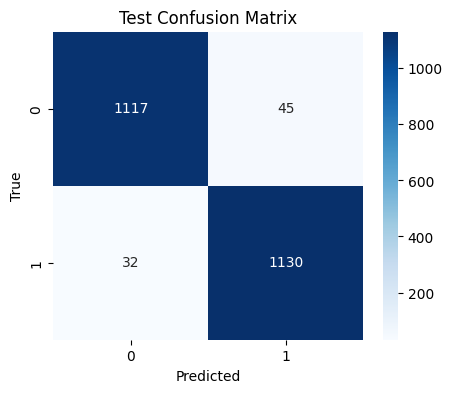

In [30]:
#Evaluation
evaluate_model(test_ds, split_name="Test")